**Connecting Sound and Language: Exploring CLAP for Zero-Shot Audio Understanding**

**By Anil Kumar**

**1. Motivation**

With the increasing availability of ambient and environmental sound recordings, there is a growing need for intuitive ways to search and organize audio content. Inspired by the capabilities of CLAP (Contrastive Language-Audio Pretraining), this project explores how audio clips can be retrieved simply by describing them in natural language. Rather than manually labeling audio files or training new models for every sound category, CLAP offers a zero-shot approach for audio understanding — opening new possibilities in accessibility, surveillance, and creative tools.

**2. CLAP Model: Methodology Explanation**

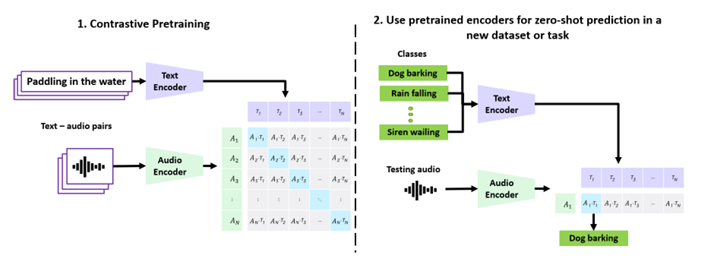

The diagram above explains how the CLAP model (Contrastive Language-Audio Pretraining) is trained and used.

In the first part (left side), during the pretraining stage, CLAP takes pairs of audio clips and their corresponding text descriptions. These are passed through an audio encoder and a text encoder, respectively. The model learns to map matching audio and text pairs close together in the embedding space, while pushing apart mismatched pairs. This is done using a contrastive learning loss, similar to how CLIP works for image-text.

In the second part (right side), once the model is trained, it can be used for zero-shot classification. Given a new, unseen audio clip, the model encodes it and compares it with the embeddings of various candidate text labels (e.g., "dog barking", "rain falling"). The model calculates the cosine similarity between the audio embedding and each text embedding, and the most similar label is selected as the prediction — all without any retraining.

This approach allows CLAP to generalize to new audio tasks without fine-tuning, making it powerful for tasks like zero-shot classification and text-based audio retrieval.

**3. Multimodal Learning: Historical Context**

Multimodal learning refers to models that process and understand information across different modalities — such as images, text, audio, and video. Early breakthroughs like CLIP (image-text) by OpenAI showed how contrastive learning enables rich, general-purpose embeddings. More recently, CLAP extended this idea to the audio domain, aligning natural language with diverse audio events. It has enabled zero-shot classification, retrieval, and audio tagging, reducing the need for task-specific data. This project leverages CLAP to demonstrate one such multimodal application — searching a folder of sound clips using free-form text queries.

**4. Learnings from the Project**

* Understanding how CLAP represents audio and text in a shared embedding space.

* Using cosine similarity to compare embeddings across modalities.

* Implementing a text-to-audio search system without fine-tuning or labeled training data.

* Visualizing model behavior using similarity scores and t-SNE projections.



**5. Workflow**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install numpy==1.26.4 --force-reinstall
!pip install laion-clap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 5.9 MB/s eta 0:00:00
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12065 sha256=6d7ec96de44d1c6f783

In [2]:
#Importing Libraries
import torch
from laion_clap import CLAP_Module
import numpy as np
import librosa
import IPython.display as ipd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [3]:
# Loading Pretrained Model
model = CLAP_Module(enable_fusion=False)
model.load_ckpt()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
Download completed!
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.weight 	 Loaded
aud

In [4]:
audio_mp3_path = "/content/drive/MyDrive/da623_project/audio/rain.mp3"

# Converting MP3 to waveform using librosa
waveform, sr = librosa.load(audio_mp3_path, sr=48000)  # 48kHz sampling for CLAP

# Pad or trim the waveform to 10 seconds (480000 samples)
if len(waveform) > 480000:
    waveform = waveform[:480000]
else:
    waveform = np.pad(waveform, (0, 480000 - len(waveform)), mode="constant")

# Converting to torch tensor and adding batch dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_input = torch.from_numpy(waveform).unsqueeze(0).to(device)

# Encoding the audio to an embedding
with torch.no_grad():
    audio_embed = model.get_audio_embedding_from_data(x=audio_input, use_tensor=True).cpu().numpy()

# Defining candidate text labels
labels = ["rain", "car horn", "dog barking", "footsteps", "clapping", "thunderstorm"]
text_inputs = [f"A sound of {label}" for label in labels]

# Encoding the text labels
with torch.no_grad():
    text_embed = model.get_text_embedding(text_inputs, use_tensor=False)

# Computing cosine similarity between audio and each text label
scores = 1 - cdist(audio_embed, text_embed, metric="cosine")

# Printing all scores
print("\nSimilarity Scores:")
for label, score in zip(labels, scores[0]):
    print(f"{label}: {score:.4f}")

# Get best match
predicted_label = labels[np.argmax(scores[0])]
print(f"\nPredicted sound: {predicted_label}")



Similarity Scores:
rain: 0.4888
car horn: 0.1238
dog barking: 0.0259
footsteps: 0.1205
clapping: 0.1927
thunderstorm: 0.3389

Predicted sound: rain


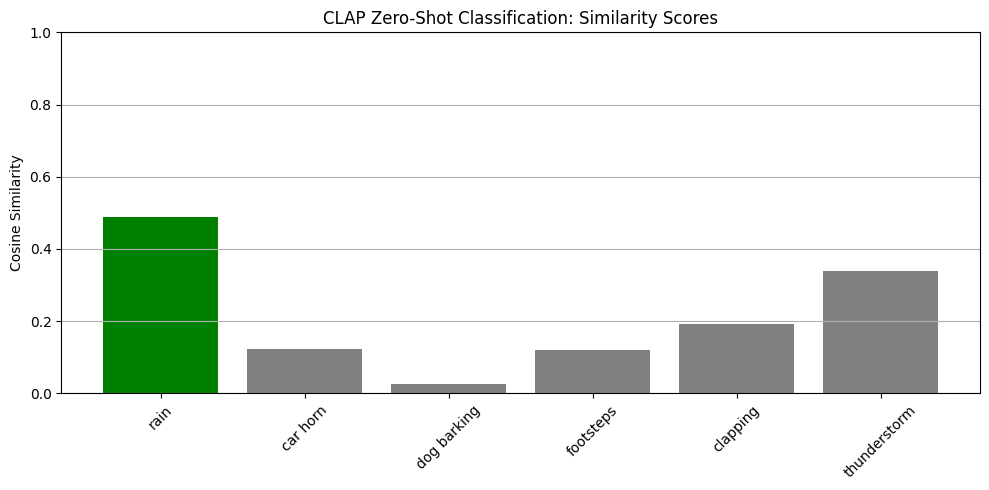

In [5]:
# Visualize the similarity scores
best_idx = np.argmax(scores[0])
bar_colors = ['gray'] * len(labels)
bar_colors[best_idx] = 'green'  # highlighting the top prediction

plt.figure(figsize=(10, 5))
plt.bar(labels, scores[0], color=bar_colors)
plt.title("CLAP Zero-Shot Classification: Similarity Scores")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

This bar chart shows the similarity scores between a user-provided audio clip and several text labels using the CLAP model. Each bar represents how closely the model believes the audio matches a specific sound description based on cosine similarity (1 = perfect match, 0 = completely unrelated). In this example, the label "rain" has the highest similarity score and is highlighted in green, meaning the model confidently identified the audio as rain. Other labels like "car horn", "dog barking", and "footsteps" received lower scores, showing that the model correctly distinguished them as less relevant. This visualization helps interpret the model’s prediction and shows how confident it is across different label options.

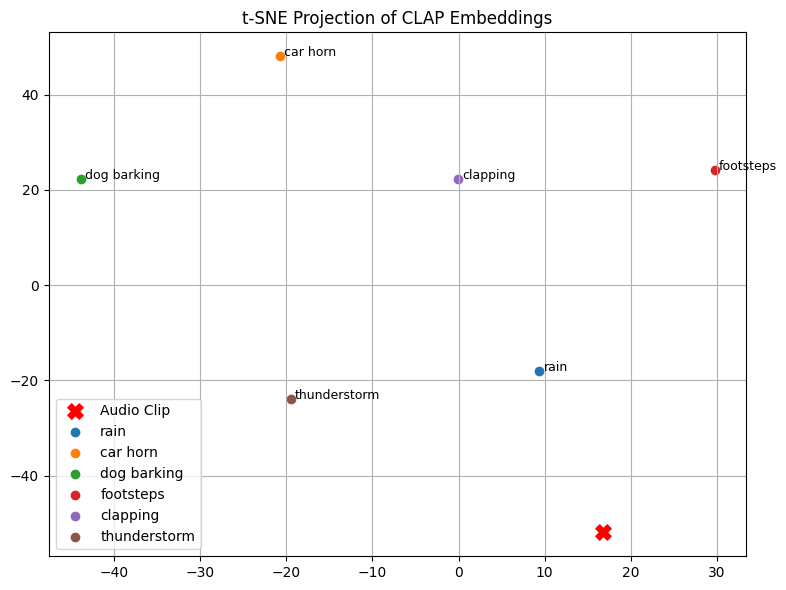

In [6]:
from sklearn.manifold import TSNE

# Combining embeddings into a single matrix for visualization
all_embeddings = np.vstack([audio_embed, text_embed])

# Using t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=5, init='pca', random_state=42)
reduced = tsne.fit_transform(all_embeddings)

# First point is the audio clip, rest are text prompts
audio_point = reduced[0]
text_points = reduced[1:]

# Plotting the 2D t-SNE embedding
plt.figure(figsize=(8, 6))
plt.scatter(audio_point[0], audio_point[1], c='red', label='Audio Clip', marker='X', s=120)
for i, label in enumerate(labels):
    plt.scatter(text_points[i][0], text_points[i][1], label=label)
    plt.text(text_points[i][0] + 0.5, text_points[i][1], label, fontsize=9)

plt.title("t-SNE Projection of CLAP Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The CLAP model generates 512-dimensional embeddings for both audio and text inputs. To visualize their relationships, dimensionality reduction is applied using t-SNE (t-distributed Stochastic Neighbor Embedding), which compresses the high-dimensional data into 2D while preserving the relative similarities between points. The resulting 2D plot shows the audio clip as a point along with multiple text label points. Proximity between the audio point and a label indicates higher semantic similarity, helping interpret which label the model associates most closely with the audio.

**Audio-to-Text Retrieval (semantic search)**



Best matching caption: Bird chirping in the morning

All similarity scores:
Bird chirping in the morning: 0.3095
Crow cawing near a window: 0.2459
Pigeon cooing softly: 0.0649
Wind rustling through trees: 0.0287
Rain falling on a rooftop: -0.0563
Thunder rumbling in the distance: 0.0261
Dog barking nearby: -0.0013
Cat meowing softly: 0.0447
Children laughing and playing: 0.0498
Footsteps on a gravel path: 0.1027
Traffic passing on a busy street: 0.0943
Door creaking open: -0.0801
Clock ticking in a quiet room: -0.1234


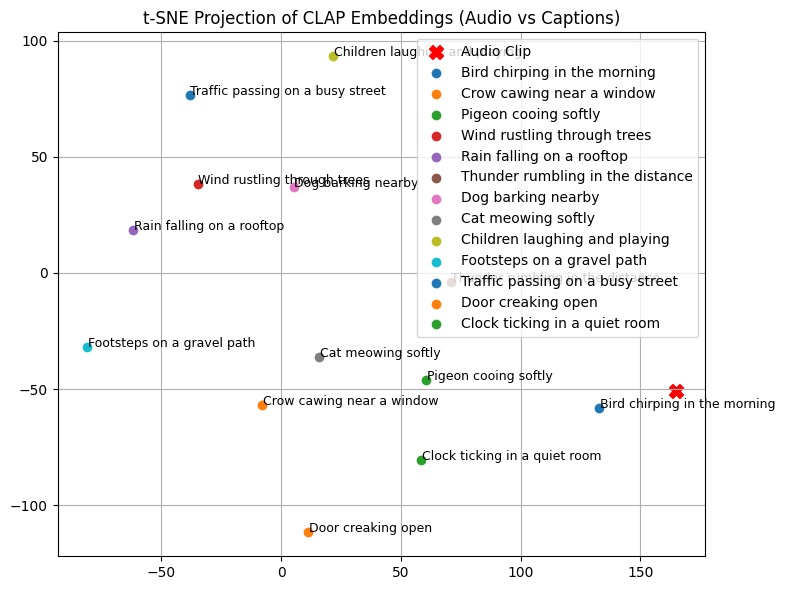

In [7]:
# Loading audio and resample to 48kHz
audio_path = "/content/drive/MyDrive/da623_project/audio/birdchirping.mp3"
waveform, sr = librosa.load(audio_path, sr=48000)

# Pad/trim to 10 seconds
if len(waveform) > 480000:
    waveform = waveform[:480000]
else:
    waveform = np.pad(waveform, (0, 480000 - len(waveform)), mode="constant")

# Converting to tensor
audio_input = torch.from_numpy(waveform).unsqueeze(0).to(device)

# Getting audio embedding
with torch.no_grad():
    audio_embed = model.get_audio_embedding_from_data(x=audio_input, use_tensor=True).cpu().numpy()

captions = [
    "Bird chirping in the morning",
    "Crow cawing near a window",
    "Pigeon cooing softly",
    "Wind rustling through trees",
    "Rain falling on a rooftop",
    "Thunder rumbling in the distance",
    "Dog barking nearby",
    "Cat meowing softly",
    "Children laughing and playing",
    "Footsteps on a gravel path",
    "Traffic passing on a busy street",
    "Door creaking open",
    "Clock ticking in a quiet room"
]


# Encoding text captions
with torch.no_grad():
    text_embed = model.get_text_embedding(captions, use_tensor=False)

# Computing cosine similarity
scores = 1 - cdist(audio_embed, text_embed, metric="cosine")

# Get best match
top_idx = int(np.argmax(scores[0]))
best_caption = captions[top_idx]

# Print results
print("Best matching caption:", best_caption)
print("\nAll similarity scores:")
for caption, score in zip(captions, scores[0]):
    print(f"{caption}: {score:.4f}")

# t-SNE visualization of audio vs text embeddings
all_embeddings = np.vstack([audio_embed, text_embed])  # shape: (10, 512)
tsne = TSNE(n_components=2, perplexity=5, init='pca', random_state=42)
reduced = tsne.fit_transform(all_embeddings)

audio_point = reduced[0]
text_points = reduced[1:]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(audio_point[0], audio_point[1], color='red', marker='X', s=100, label='Audio Clip')
for i, point in enumerate(text_points):
    plt.scatter(point[0], point[1], label=captions[i])
    plt.text(point[0] + 0.3, point[1], captions[i], fontsize=9)

plt.title("t-SNE Projection of CLAP Embeddings (Audio vs Captions)")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


This t-SNE plot visualizes the high-dimensional CLAP embeddings of one audio clip and multiple text captions by reducing them into a 2D space. The red "X" represents the embedding of the input audio clip, while the colored dots represent the embeddings of candidate text captions like “bird chirping in the morning,” “rain falling on a rooftop,” and “dog barking nearby.”

The closer a text point is to the audio point, the more semantically similar the CLAP model considers them. In this plot, the audio embedding is positioned nearest to the caption “bird chirping in the morning,” which indicates that the model predicts this as the most relevant label for the given audio.

**Audio Search Engine (Text-to-Audio Retrieval)**

In [8]:
# Function to embed a single audio file
def embed_audio_file(path):
    waveform, sr = librosa.load(path, sr=48000)
    if len(waveform) > 480000:
        waveform = waveform[:480000]
    else:
        waveform = np.pad(waveform, (0, 480000 - len(waveform)), mode="constant")
    audio_tensor = torch.from_numpy(waveform).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.get_audio_embedding_from_data(x=audio_tensor, use_tensor=True).cpu().numpy()
    return embedding


In [9]:
# Embedding all audio files in a folder
import os
AUDIO_FOLDER = "/content/drive/MyDrive/da623_project/audio"

audio_db = {}
for file in os.listdir(AUDIO_FOLDER):
    if file.endswith((".wav", ".mp3")):
        path = os.path.join(AUDIO_FOLDER, file)
        print(f"Indexing: {file}")
        audio_db[file] = embed_audio_file(path)

print(f"Indexed {len(audio_db)} audio files.")


Indexing: parrots-26716.mp3
Indexing: birdchirping.mp3
Indexing: basket.mp3
Indexing: Ball+Hit+Cheer.mp3
Indexing: oceanwave.mp3
Indexing: Crackling_Fire.mp3
Indexing: rain_start.mp3
Indexing: AMBh.mp3
Indexing: const7.mp3
Indexing: Baby+Cry+1.mp3
Indexing: Phone_Ring.mp3
Indexing: Airplane+1.mp3
Indexing: gun-shots-230534.mp3
Indexing: sound-effect-machine-gun-333524.mp3
Indexing: Parrot-sound.mp3
Indexing: rain.mp3
Indexed 16 audio files.


Enter a sound description (e.g., 'crow cawing'): gun shots

Best match: sound-effect-machine-gun-333524.mp3 (Similarity: 0.5854)



Top 3 Matches:
1. sound-effect-machine-gun-333524.mp3 — 0.5854
2. gun-shots-230534.mp3 — 0.4278
3. basket.mp3 — 0.2073


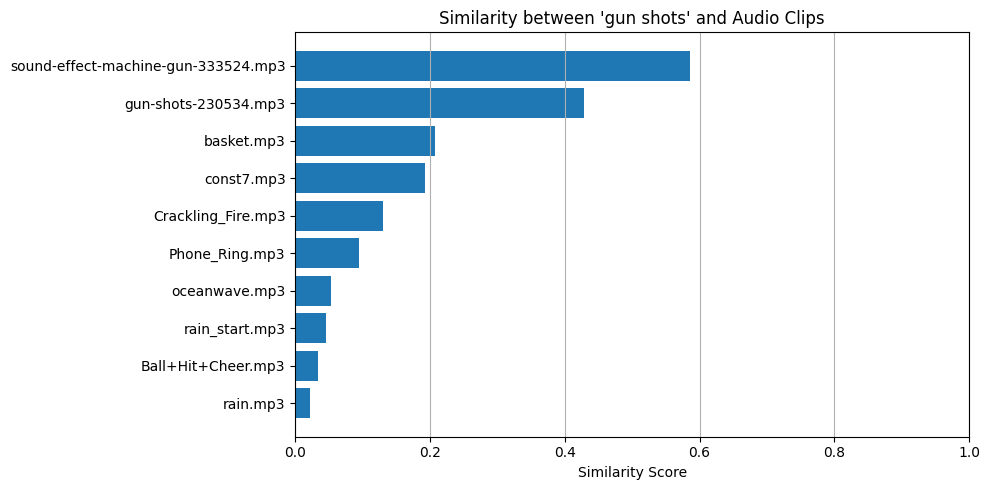

In [11]:
# Accept user text query and embed it
query = input("Enter a sound description (e.g., 'crow cawing'): ")
with torch.no_grad():
    text_embed = model.get_text_embedding([query], use_tensor=False)


# Computing similarities and retrieve best match
scores = {}
for filename, audio_embed in audio_db.items():
    similarity = 1 - cdist(audio_embed, text_embed, metric="cosine")[0][0]
    scores[filename] = similarity

# Sorting by similarity
sorted_results = sorted(scores.items(), key=lambda x: x[1], reverse=True)
best_match, best_score = sorted_results[0]

print(f"\nBest match: {best_match} (Similarity: {best_score:.4f})")
ipd.display(ipd.Audio(os.path.join(AUDIO_FOLDER, best_match)))

# Top 3 matches
print("\nTop 3 Matches:")
for i, (fname, score) in enumerate(sorted_results[:3]):
    print(f"{i+1}. {fname} — {score:.4f}")


file_names = [fname for fname, _ in sorted_results[:10]]
similarity_scores = [score for _, score in sorted_results[:10]]

# Plot
plt.figure(figsize=(10, 5))
bars = plt.barh(file_names[::-1], similarity_scores[::-1])
plt.xlabel("Similarity Score")
plt.title(f"Similarity between '{query}' and Audio Clips")
plt.xlim(0, 1)
plt.tight_layout()
plt.grid(axis='x')
plt.show()

A user provides a text description (such as “crow cawing”), and the model encodes it into a text embedding. Each audio file in a specified folder is also converted into an embedding using the same model. The system then calculates the cosine similarity between the input text embedding and all audio embeddings to identify the most semantically similar sound. The audio file with the highest similarity score is returned as the best match, and a bar chart visualizes how closely each audio file matches the given text query based on similarity scores. This enables intuitive, zero-shot text-based audio retrieval without any additional training.

**6. Reflections**

(a) *What surprised me* ?

One thing that surprised me while working on this project was how accurately the CLAP model was able to understand and match natural language queries with the correct audio clips — even when I used general or vague descriptions like “bird chirping” or “wind blowing.” I didn’t expect the model to be this good without any extra training on my audio dataset. It felt like magic that I could just describe a sound in plain English and the system would pick out the right file from my folder. I was also impressed by how versatile the model was — I could give it completely new phrases and it still made smart guesses.

Another interesting moment was when I visualized the similarity scores and the t-SNE embeddings. It made the model’s predictions more understandable and showed how the audio and text are actually being matched in a shared space.

(b) *What can be improved* ?

While CLAP is powerful, I noticed that it relies a lot on the quality and variety of the captions I provide. If I don’t include a close enough description in the caption list, the model might return the wrong audio, even if the clip is present. So the retrieval quality depends on how well I design my caption vocabulary. It also doesn’t generate captions — it only chooses from options I give it.

In the future, I think this system can be improved by allowing it to generate its own descriptions using an audio captioning model, or by combining it with a language model like GPT to expand or paraphrase captions automatically.

Overall, this project helped me understand how contrastive multimodal models like CLAP work and how they can solve real-world problems without needing retraining or supervision.


**7. Reference**

Elizalde et al., "CLAP: Learning Audio Concepts from Natural Language Supervision", arXiv 2022 — https://arxiv.org/abs/2206.04769